In [ ]:
!pip install easyocr
!pip install googletrans

     |████████████████████████████████| 63.6 MB 34 kB/s 
     |████████████████████████████████| 47.6 MB 63 kB/s 


     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 42 kB 1.7 MB/s 
     |████████████████████████████████| 1.2 MB 17.7 MB/s 
     |████████████████████████████████| 65 kB 4.3 MB/s 
     |████████████████████████████████| 53 kB 2.9 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15734 sha256=af2a290a147cd1a49983673f06d08344cebee035a20a7970cf68a4d99716454c
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


4.1.2


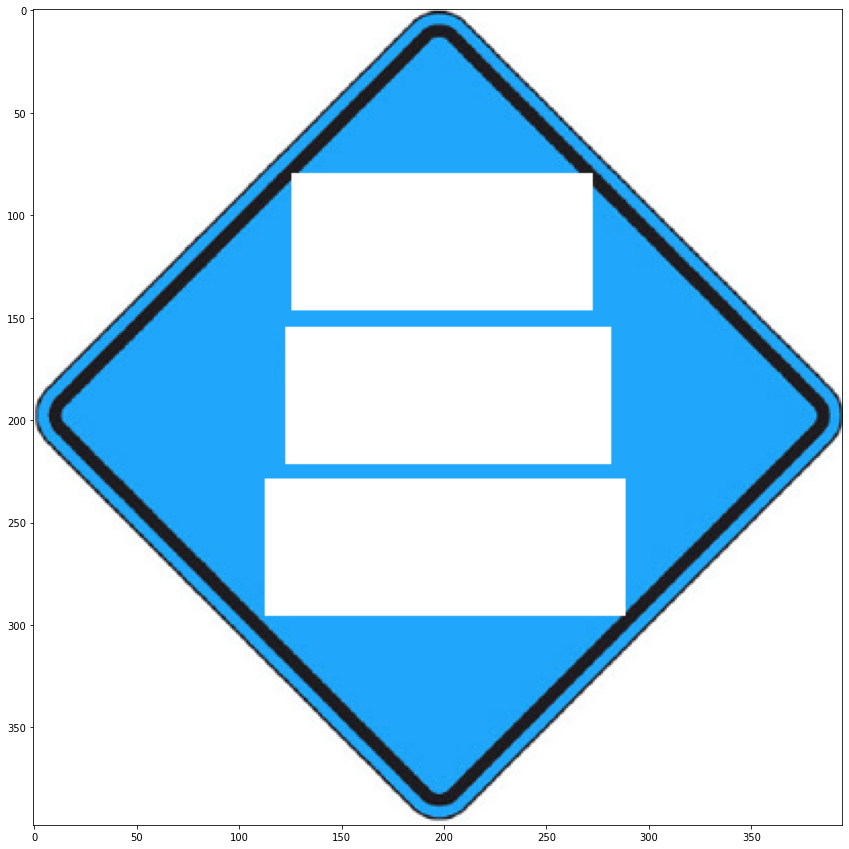

Text_list : ['ROAD', 'WORK', 'AHEAD']
Tranlated_texts : ['도로', '작업', '앞자리']
[[[126, 80], [272, 80], [272, 146], [126, 146]], [[123, 155], [281, 155], [281, 221], [123, 221]], [[113, 229], [288, 229], [288, 295], [113, 295]]]


In [ ]:
import cv2
import matplotlib.pyplot as plt
import easyocr
import sys
import googletrans
from typing import List
import requests
import pprint

from google.colab.patches import cv2_imshow
import numpy as np

from PIL import Image 
from PIL import ImageFont
from PIL import ImageDraw


# Press Shift+F10 to execute it or replace it with your code.
# Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

print(cv2.__version__)

# 이미지 파일 경로
file_path = r'2.png'
img = cv2.imread(file_path, cv2.IMREAD_COLOR)

CLIENT_ID = "MawiiHEojSbWlRvZjWEM"
CLIENT_SECRET = "gY1PNWHP54"

if img is None:
    print('Image load failed!')
    sys.exit()


# 이미지 출력함수
def display(img):
    # img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()


def cleanup_text(text):
    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV
    return "".join([c if ord(c) < 128 else "" for c in text]).strip()


def easy_ocr_result(img, language='en', draw=True, text=False):
    reader = easyocr.Reader([language])
    results = reader.readtext(img)

    # 바운딩박스 리스트
    bbox_list = []
    # 텍스트 리스트
    text_list = []

    if draw == False: # 원래 이미지만 출력
        display(img)

    elif draw == True and text == False: # 이미지에 바운딩 박스그리기
        img2 = img.copy()
        # img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
        for (bbox, text, prob) in results:
            # display the OCR'd text and associated probability
            # print("[INFO] {:.4f}: {}".format(prob, text))

            bbox_list.append(bbox)
            text_list.append(text)
            # unpack the bounding box
            (tl, tr, br, bl) = bbox
            tl = (int(tl[0]), int(tl[1]))
            tr = (int(tr[0]), int(tr[1]))
            br = (int(br[0]), int(br[1]))
            bl = (int(bl[0]), int(bl[1]))
            # cleanup the text and draw the box surrounding the text along
            # with the OCR'd text itself
            cv2.rectangle(img2, tl, br, (255, 255, 255), -1) # white box

        # show the output image
        display(img2)



    elif draw == True and text == True:  # 이미지에 바운딩 + 인식한 글자
        img2 = img.copy()
        # img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

        for (bbox, text, prob) in results:
            # display the OCR'd text and associated probability
            # print("[INFO] {:.4f}: {}".format(prob, text))

            bbox_list.append(bbox)
            text_list.append(text)

            # unpack the bounding box
            (tl, tr, br, bl) = bbox
            tl = (int(tl[0]), int(tl[1]))
            tr = (int(tr[0]), int(tr[1]))
            br = (int(br[0]), int(br[1]))
            bl = (int(bl[0]), int(bl[1]))
            # cleanup the text and draw the box surrounding the text along
            # with the OCR'd text itself
            text = cleanup_text(text)
            cv2.rectangle(img2, tl, br, (255, 0, 0), 2)
            cv2.putText(img2, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), -1) # white box

        # show the output image
        display(img2)
    return bbox_list, text_list


def translate_texts(texts: List[str], type='google') -> List[str]:
    global tranlated_texts
    if type == 'google':
        translator = googletrans.Translator()
        tranlated_texts = [
            translator.translate(text=text, src='en', dest='ko').text
            for text in texts
        ]
    elif type == 'naver':
        url = "https://openapi.naver.com/v1/papago/n2mt"
        header = {"X-Naver-Client-Id": CLIENT_ID, "X-Naver-Client-Secret": CLIENT_SECRET}
        tranlated_texts = []
        for text in texts:
            data = {'text': text, 'source': 'en', 'target': 'ko'}
            response = requests.post(url, headers=header, data=data)
            rescode = response.status_code
            if rescode == 200:
                t_data = response.json()
                tranlated_texts.append(t_data['message']['result']['translatedText'])
            else:
                print("Error Code:", rescode)

    return tranlated_texts


# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    bbox_list, text_list = easy_ocr_result(img)
    print('Text_list :', text_list)
    tranlated_texts: List[str] = translate_texts(texts=text_list, type='naver')
    print(f'Tranlated_texts : {tranlated_texts}')
    print(bbox_list)

# ------------------------------------

# 바운딩 박스만 White로 바꾸고 아래것 실행 하면됩니다, bbox_list
# 글자 폰트는 한글 지원되는 것만 가능 (한글번역이라)
# 원본 파일 적는곳이 지금 3군데임 file_path



# make mask : step 1
# Load image
img = cv2.imread(file_path)

# Initialize blank mask image of same dimensions for drawing the shapes
shapes = np.zeros_like(img, np.uint8)

# Draw shapes
cv2.rectangle(shapes, tuple(bbox_list[0][0]), tuple(bbox_list[0][2]), (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, tuple(bbox_list[1][0]), tuple(bbox_list[1][2]), (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, tuple(bbox_list[2][0]), tuple(bbox_list[2][2]), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, tuple(bbox_list[3][0]), tuple(bbox_list[3][2]), (255, 255, 255), cv2.FILLED)

# Generate output by blending image with shapes image, using the shapes
# images also as mask to limit the blending to those parts
out = img.copy()
alpha = 0.01
mask = shapes.astype(bool)
out[mask] = cv2.addWeighted(img, alpha, shapes, 1 - alpha, 0)[mask]

# Visualization & Save
# cv2_imshow(shapes)
cv2.imwrite("shapes.jpg", shapes)




# inpaint : step2
# img = cv2.imread('target.jpg')
img = cv2.imread(file_path)
mask = cv2.imread('shapes.jpg',0)
dst = cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)

# Visualization & Save
# cv2_imshow(dst)
cv2.imwrite("inpaint.jpg", dst)




# rewrite : step3
# Font
font = ImageFont.truetype("NotoSansKR-Black.otf", 58)
img = Image.open('inpaint.jpg')

draw = ImageDraw.Draw(img)

draw.text(bbox_list[0][0], tranlated_texts[0], (0,0,0), font=font)
draw.text(bbox_list[1][0], tranlated_texts[1], (0,0,0), font=font)
draw.text(bbox_list[2][0], tranlated_texts[2], (0,0,0), font=font)
# draw.text(bbox_list[3][0], tranlated_texts[3], (0,0,0), font=font)

img.show()
img.save("img_text.jpg")



In [ ]:
# 바운딩 박스만 White로 바꾸고 아래것 실행 하면됩니다, bbox_list
# 글자 폰트는 한글 지원되는 것만 가능 (한글번역이라)
# 원본 파일 적는곳이 지금 3군데임
from google.colab.patches import cv2_imshow

import numpy as np

from PIL import Image 
from PIL import ImageFont
from PIL import ImageDraw



# make mask : step 1
# Load image
img = cv2.imread('2.png') 

# Initialize blank mask image of same dimensions for drawing the shapes
shapes = np.zeros_like(img, np.uint8)

# Draw shapes
cv2.rectangle(shapes, tuple(bbox_list[0][0]), tuple(bbox_list[0][2]), (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, tuple(bbox_list[1][0]), tuple(bbox_list[1][2]), (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, tuple(bbox_list[2][0]), tuple(bbox_list[2][2]), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, tuple(bbox_list[3][0]), tuple(bbox_list[3][2]), (255, 255, 255), cv2.FILLED)

# Generate output by blending image with shapes image, using the shapes
# images also as mask to limit the blending to those parts
out = img.copy()
alpha = 0.01
mask = shapes.astype(bool)
out[mask] = cv2.addWeighted(img, alpha, shapes, 1 - alpha, 0)[mask]

# Visualization & Save
cv2_imshow(shapes)
cv2.imwrite("shapes.jpg", shapes)




# inpaint : step2
# img = cv2.imread('target.jpg')
img = cv2.imread('2.png')
mask = cv2.imread('shapes.jpg',0)
dst = cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)

# Visualization & Save
cv2_imshow(dst)
cv2.imwrite("inpaint.jpg", dst)



# rewrite : step3
# Font
font = ImageFont.truetype("NotoSansKR-Black.otf", 58)
img = Image.open('inpaint.jpg')

draw = ImageDraw.Draw(img)

draw.text(bbox_list[0][0], tranlated_texts[0], (0,0,0), font=font)
draw.text(bbox_list[1][0], tranlated_texts[1], (0,0,0), font=font)
draw.text(bbox_list[2][0], tranlated_texts[2], (0,0,0), font=font)
draw.text(bbox_list[3][0], tranlated_texts[3], (0,0,0), font=font)

img.show()
img.save("img_text.jpg")

In [ ]:
# ##### 끝

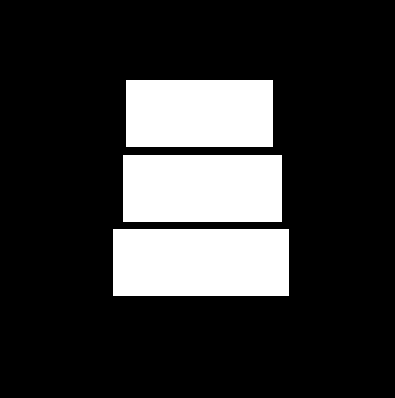

True

In [ ]:
# shapes
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Load image
img = cv2.imread(file_path)

# Initialize blank mask image of same dimensions for drawing the shapes
shapes = np.zeros_like(img, np.uint8)

# Draw shapes
cv2.rectangle(shapes, tuple(bbox_list[0][0]), tuple(bbox_list[0][2]), (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, tuple(bbox_list[1][0]), tuple(bbox_list[1][2]), (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, tuple(bbox_list[2][0]), tuple(bbox_list[2][2]), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, tuple(bbox_list[3][0]), tuple(bbox_list[3][2]), (255, 255, 255), cv2.FILLED)


# cv2.rectangle(shapes, (163, 323), (333, 385), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, (158, 380), (398, 458), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, (157, 442), (406, 527), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, (157, 511), (278, 591), (255, 255, 255), cv2.FILLED)


# Generate output by blending image with shapes image, using the shapes
# images also as mask to limit the blending to those parts
out = img.copy()
alpha = 0.01
mask = shapes.astype(bool)
out[mask] = cv2.addWeighted(img, alpha, shapes, 1 - alpha, 0)[mask]

# Visualization
# cv2_imshow(img)
cv2_imshow(shapes)

# cv2_imshow(out)


#
cv2.imwrite("shapes.jpg", shapes)

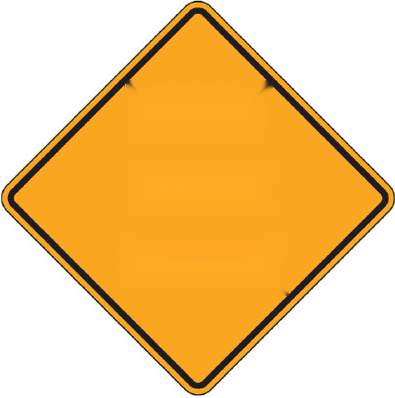

True

In [ ]:

# import numpy as np
# import cv2
# from google.colab.patches import cv2_imshow

img = cv2.imread(file_path)
mask = cv2.imread('shapes.jpg',0)
dst = cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)
cv2_imshow(dst)

# 저장
cv2.imwrite("inpaint.jpg", dst)

In [ ]:
from PIL import Image 
from PIL import ImageFont
from PIL import ImageDraw


# db.set_character_set('utf8')
# dbc.execute('SET NAMES utf8;')
# dbc.execute('SET CHARACTER SET utf8;')
# dbc.execute('SET character_set_connection=utf8;')


# font = ImageFont.load_default()
font = ImageFont.truetype("NotoSansKR-Black.otf", 58)

img = Image.open('inpaint.jpg')


draw = ImageDraw.Draw(img)
# draw.text((163, 323), (333, 385)),"AAAAAAAAAAA!",(0,0,0),font=font)
# draw.text((158, 380), (398, 458)),"BBBBBBB & !",(0,0,0),font=font)
# draw.text((157, 442), (406, 527)),"CCCCCC !",(0,0,0),font=font)
# draw.text((157, 511), (278, 591)),"DDDDD !",(0,0,0),font=font)



# draw.text((163, 323),"환  자 ",(0,0,0),font=font)
# draw.text((158, 380),"픽  업  & ",(0,0,0),font=font)
# draw.text((157, 442),"퇴  원 ",(0,0,0),font=font)
# draw.text((157, 511),"오  직 ",(0,0,0),font=font)


draw.text(bbox_list[0][0], tranlated_texts[0], (0,0,0), font=font)
draw.text(bbox_list[1][0], tranlated_texts[1], (0,0,0), font=font)
draw.text(bbox_list[2][0], tranlated_texts[2], (0,0,0), font=font)
# draw.text(bbox_list[3][0], tranlated_texts[3], (0,0,0), font=font)







# img.show()

img.save("img_text.jpg")


